# faimed3d Dataloaders for 3D images

In [ ]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [ ]:
# export
# default_exp data

import SimpleITK as sitk
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *

In [ ]:
# export
from faimed3d.basics import *
from faimed3d.preprocess import *
from faimed3d.augment import *


## Get data paths and labels

Data is divided into a train, valid and test dataset of different patients, which either have prostate cancer or are healthy. 
Each patient has three MRI sequences: T2, T1map and ADC. These sequences differ in number of slices and resolution. 

At first the paths to the data are specified: 

In [ ]:
d =  pd.read_csv('../../mri-spa/data/train_knee.csv')

In [ ]:
# export
class PreprocessDicom(DisplayedTransform):
    "Transforms a TensorDicom3D volume to float and normalizes the data"
    def __init__(self, rescale=True, 
                 correct_spacing=True, spacing = 1,
                 correct_orientation=False, orientation=(0,0,0,0,0,0),
                 clip_high_values=False, clipping_range=(-2000, 10000)): 
        """
        Args:
            rescale (bool): if pixel values should be scaled according to the rescale intercept and slope
            correct_spacing (bool): if spacing of all volumes should be set to a unified value.
            spacing (int): new pixel spacing, default is 1.
            correct_orientation (bool): if orientation of volumes should be the same across all items. 
            orientation (tuple): new porientation. 
            clip_high_values (bool): if abriatry high values shoule be clipped
            clipping_rang (tuple or list): min and maximum to clip values
        """
        
        store_attr()
    def encodes(self, x:(TensorDicom3D, TensorMask3D)):
        if isinstance(x, TensorMask3D): return x
        if hasattr(x, 'metadata'): # numpy arrays will not have metadata
            if self.rescale: x = x.rescale_pixeldata()
            if self.correct_spacing: x = x.size_correction(self.spacing)
            if self.correct_orientation: raise NotImplementedError()
        if self.clip_high_values: x = x.clamp(self.clipping_range[0], 
                                              self.clipping_range[1])
        return x.float()

In [ ]:
# export
def ImageBlock3D(cls=TensorDicom3D, **kwargs):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, batch_tfms=[PreprocessDicom(**kwargs)])

def MaskBlock3D(cls=TensorMask3D, codes=None):
    "A `TransformBlock` for images of `cls`. For possible kwargs see PreporcessDicom."
    return TransformBlock(type_tfms=cls.create, item_tfms=AddMaskCodes(codes=codes))

## Dataloaders for image classification problems

In [ ]:
# export
class ImageDataLoaders3D(DataLoaders):
    "Enarly identitcal to fastai `ImageDataLoaders` but adapted for 3D data with some preprocessing steps added"
    
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, clean_tmpdir=True,**kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        
        if clean_tmpdir:
            print('Cleaning tmpdir.')
            cleanup_tmpdir() # clean up tmpdir from last session
            print('You can disable automatic cleanup of the tmpdir (e.g. when doing multiple sessions in parallel)'
                  ' with setting clean_tmpdir=False')
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        if rescale_method is None: 
            print('No rescale method was used. This is not advisable due to high risk of exploding gradients. '
                  'Falling back to mean scaling.')
            rescale_method = MeanScale()
        item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]

        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    
    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, item_tfms=None,
                    batch_tfms=None, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/), if you need this feature implemented. ')

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`"
        raise NotImplementedError('Currently only from_df and from_csv are supported. '
                                  'You can raise a feature request on Github (https://github.com/kbressem/faimed3d/), if you need this feature implemented. ')

    @classmethod
    def from_name_func(cls, path, fnames, label_func, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with `label_func`"
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, **kwargs):
        "Create from list of `fnames` in `path`s with re expression `pat`"
        return cls.from_path_func(path, fnames, RegexLabeller(pat), **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, **kwargs):
        "Create from the name attrs of `fnames` in `path`s with re expression `pat`"
        return cls.from_name_func(path, fnames, RegexLabeller(pat), **kwargs)


In [ ]:
#export
class SegmentationDataLoaders3D(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    
    def from_df(cls, df, path='.', valid_pct=0.2, seed=None, fn_col=0, folder=None, suff='', label_col=1, codes=None,
                valid_col=None, item_tfms=None, batch_tfms=None, rescale_method=None, clean_tmpdir=True,**kwargs):
        "Create from `df` using `fn_col` and `label_col`"
        
        if clean_tmpdir:
            print('Cleaning tmpdir.')
            cleanup_tmpdir() # clean up tmpdir from last session
            print('You can disable automatic cleanup of the tmpdir (e.g. when doing multiple sessions in parallel)'
                  ' with setting clean_tmpdir=False')
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        if rescale_method is None: 
            print('No rescale method was used. This is not advisable, due to high risk of exploding gradients. '
                  'Falling back to mean scaling.')
            rescale_method = MeanScale()
        item_tfms = [rescale_method, *item_tfms] if isinstance(item_tfms, list) else [rescale_method, item_tfms]

        dblock = DataBlock(blocks=(ImageBlock3D(cls=TensorDicom3D), MaskBlock3D(codes=codes)),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, pref=pref, suff=suff),
                           splitter=splitter,
                           item_tfms=[rescale_method, item_tfms],
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    
    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        "Create from `path/csv_fname` using `fn_col` and `label_col`"
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)

In [ ]:
dls = ImageDataLoaders3D.from_df(d, path='/media/..', 
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True),
                                 batch_size = 2)

Cleaning tmpdir.
removing 3 files from /tmp/faimed3d_metadata/
You can disable automatic cleanup of the tmpdir (e.g. when doing multiple sessions in parallel) with setting clean_tmpdir=False
No rescale method was used. This is not advisable, due to high risk of exploding gradients. Falling back to mean scaling.


In [ ]:
# export
@patch
def show_batch_3d(dls:DataLoaders, max_n=9, with_mask=False, alpha_mask=0.3, figsize = (15, 15), **kwargs):
    "Workarround, until implemented into dls as dls.show_batch_3d()"
    xb, yb = dls.one_batch()
    xb.show(figsize=figsize, **kwargs)
    if with_mask: yb.show(add_to_existing = True, alpha = alpha_mask, cmap = 'jet', figsize=figsize, **kwargs)    

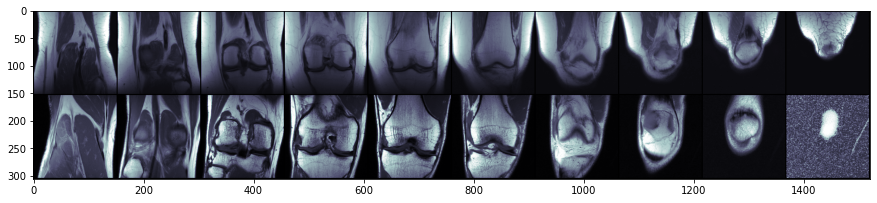

In [ ]:
dls.show_batch_3d(axis = 0, nrow = 10)

Cleaning tmpdir.
removing 4 files from /tmp/faimed3d_metadata/
You can disable automatic cleanup of the tmpdir (e.g. when doing multiple sessions in parallel) with setting clean_tmpdir=False
No rescale method was used. This is not advisable, due to high risk of exploding gradients. Falling back to mean scaling.


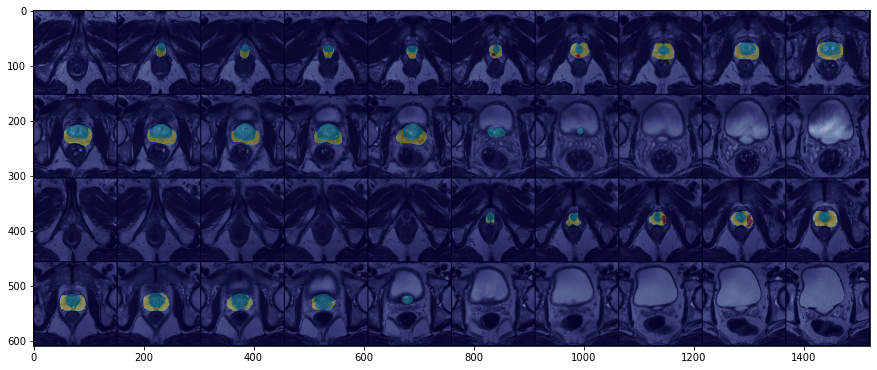

In [ ]:
prostate = pd.read_csv('../../dl-prostate-mapping/data/prostata-train.csv', sep = ',')
prostate = prostate[['t2_dcm_path', 't2_mask_base']]
dls = SegmentationDataLoaders3D.from_df(prostate, path='/media/..', 
                                 item_tfms = ResizeCrop3D(crop_by = (0., 0.1, 0.1), resize_to = (20, 150, 150), perc_crop = True), 
                                 batch_size = 2)
dls.show_batch_3d(axis = 0, nrow = 10, with_mask = True)

When displaying the masks it may occure, that Nifti images are rotated and do not fit the original DICOM. Most likely it is due to different frames of reference. 
in Simple-ITK it is LPS, while NIfTI and FSL use RAS, so those matrices are the same after accounting for frame of reference (taken and adapted from https://discourse.itk.org/t/nifti-orientation-issues/431).
So, luckly the malrotations are systematic and can be scripted.

```python
    def convert(fn):

        if 'Gesund' in fn: return # healthy patients were already flipped once
        im = sitk.ReadImage(fn)
        arr = sitk.GetArrayFromImage(im)
        arr = np.rot90(arr, 0)
        arr = np.flip(arr, 1)
        im2 = sitk.GetImageFromArray(arr)

        for k in im.GetMetaDataKeys(): # Copy meta data from original image before overwriting it. 
            im2.SetMetaData(k, im.GetMetaData(k))

        sitk.WriteImage(im2, fn)
        return im2
    
    
    for s in segmentation_train: 
    convert(str(s))
````

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 01_basics.ipynb.
Converted 02_preprocessing.ipynb.
Converted 03_transforms.ipynb.
Converted 04_dataloaders.ipynb.
Converted 05a_models.modules.ipynb.
Converted 05b_models.alexnet.ipynb.
Converted 05b_models.deeplabv3.ipynb.
Converted 05b_models.densenet.ipynb.
Converted 05b_models.resnet.ipynb.
Converted 05c_models.DynamicUnet.ipynb.
Converted 05c_models.siamese.ipynb.
Converted 05c_models.unet.ipynb.
Converted 05d_models.losses.ipynb.
Converted 06_callback.ipynb.
Converted 99_tools.ipynb.
Converted index.ipynb.
